In [59]:
import gurobipy as gp
from gurobipy import GRB

#Initial parameters
Depot=1# depot
Parking=2# two evacuation points
Safe=2# two safe points
Buses=1# two buses

demands=[3, 5]# demand of evacuees
capacities=[8, 1]# capacity of safe points

dist_start=[4, 7]# distance between depots and evacuation points
dist={(0,0):6,(0,1):4,(1,0):6,(1,1):7} # distance between evacuation points and safe points

Bus_capacity=3 # capacity of buses
#Rounds=sum(demands)# biggest evacuation rounds
#Rounds2=sum(demands)-1
Rounds=int(sum(demands)/Bus_capacity)+1
Rounds2=Rounds-1
# Create a Gurobi model
m = gp.Model("evacuation_problem")

# Variables
x = m.addVars(Buses, Parking, Safe, Rounds, vtype=GRB.BINARY, name="x") #binary 
t_to = m.addVars(Buses,Rounds, vtype=GRB.CONTINUOUS, name="t_to")
t_back = m.addVars(Buses,Rounds, vtype=GRB.CONTINUOUS, name="t_back")
t_max = m.addVar(vtype=GRB.CONTINUOUS, name="t_max")
t_avg = m.addVars(Buses,Rounds,vtype=GRB.CONTINUOUS, name="t_avg")
#t_avg = m.addVars(Buses, Parking, Rounds,vtype=GRB.CONTINUOUS, name="t_avg")
b_parking=m.addVars(Buses, Parking, Rounds, lb=0,vtype=GRB.CONTINUOUS,name="b_parking")

# Objective function

# total 
m.setObjective(t_max, GRB.MINIMIZE)

# average evacuation time
#m.setObjective(gp.quicksum(t_avg[b,r] for b in range(Buses) for r in range(Rounds)), GRB.MINIMIZE)
#m.setObjective(gp.quicksum(b_parking[b,p,r]*t_avg[b,p,r] for b in range(Buses) for p in range(Parking) for r in range(Rounds))/sum(demands), GRB.MINIMIZE)

'''
m.setObjectiveN(t_max, GRB.MINIMIZE, priority=9)
m.setObjectiveN(gp.quicksum(t_avg[b,r] for b in range(Buses) for r in range(Rounds)), GRB.MINIMIZE,priority=1)
'''



# Constraints
# pick up and delivery time 
for b in range(0,Buses):
    for r in range(0,Rounds):
        m.addConstr(t_to[b,r]>=gp.quicksum(dist[(p,s)]*x[b,p,s,r] for p in range(0,Parking) for s in range(0, Safe)))

# next round evacuation 
for b in range(Buses):
    for r in range(Rounds2):
        for p in range(Parking):
            for s in range(Safe):
                m.addConstr(t_back[b,r]>=dist[(p,s)]*(gp.quicksum(x[b,i,s,r] for i in range(Parking))+gp.quicksum(x[b,p,l,r+1] for l in range(Safe))-1))

#total time
for b in range(Buses):
    m.addConstr(t_max>= gp.quicksum(t_to[b,r]+t_back[b,r] for r in range(Rounds))+gp.quicksum(dist_start[p]*x[b,p,l,0] for p in range(Parking) for l in range(Safe)))
    #m.addConstr(t_min<= gp.quicksum(t_to[b,r]+t_back[b,r] for r in range(Rounds))+gp.quicksum(dist_start[p]*x[b,p,l,0] for p in range(Parking) for l in range(Safe)))

#averge time for each bus in each round
'''
for b in range(Buses):
    for r in range(Rounds):
        for j in range(Parking):
            #m.addConstr(t_avg[b,r]== gp.quicksum(x[b,p,s,r] for p in range(Parking) for s in range(Safe))*(gp.quicksum(t_to[b,r_x]+t_back[b,r_x] for r_x in range(r))+gp.quicksum(dist_start[p]*x[b,p,l,0] for p in range(Parking) for l in range(Safe))))
            m.addConstr(t_avg[b,j,r]== gp.quicksum(x[b,j,s,r] for s in range(Safe))*(gp.quicksum(t_to[b,r_x]+t_back[b,r_x] for r_x in range(r))+gp.quicksum(dist_start[p]*x[b,p,l,0] for p in range(Parking) for l in range(Safe))))

for b in range(Buses):
    for r in range(Rounds):
            m.addConstr(t_avg[b,r]>= gp.quicksum(x[b,p,s,r] for p in range(Parking) for s in range(Safe))*(gp.quicksum(t_to[b,r_x]+t_back[b,r_x] for r_x in range(r))+gp.quicksum(dist_start[p]*x[b,p,l,0] for p in range(Parking) for l in range(Safe))))
'''
#one trip for every bus
for b in range(Buses):
    for r in range(Rounds):
        m.addConstr(gp.quicksum(x[b,p,s,r] for p in range(Parking) for s in range(Safe))<=1)

# first trip constraint
for b in range(Buses):
    m.addConstr(gp.quicksum(x[b,p,s,0] for p in range(Parking) for s in range(Safe))==1)

# flow constraints
for b in range(Buses):
    for r in range(Rounds2):
        m.addConstr(gp.quicksum(x[b,p,s,r] for p in range(Parking) for s in range(Safe))>=gp.quicksum(x[b,p,s,r+1] for p in range(Parking) for s in range(Safe)))

#bus capacity
for p in range(Parking):
    for b in range(Buses):
        for r in range(Rounds):
            m.addConstr(b_parking[b,p,r]<=Bus_capacity*gp.quicksum(x[b,p,s,r] for s in range(Safe)))
#demand 
for p in range(Parking):
    m.addConstr(gp.quicksum(b_parking[b,p,r]*x[b,p,s,r] for b in range(Buses) for s in range(Safe) for r in range(Rounds))>=demands[p])
#safe points capacity
for s in range(Safe):
    m.addConstr(gp.quicksum(b_parking[b,p,r]*x[b,p,s,r] for b in range(Buses) for p in range(Parking) for r in range(Rounds))<=capacities[s])

# evacuation sutdown
for b in range(Buses):
    for r in range(int(Rounds/3),Rounds):
        m.addConstr(gp.quicksum(x[b,0,s,r] for s in range(Safe))==0)
#m.setParam(GRB.Param.MIPGap,0.01)
m.setParam(GRB.Param.TimeLimit,120)
# Optimize the model
m.optimize()

for v in m.getVars():
    print('%s %g' % (v.varName, v.x))




Set parameter TimeLimit to value 120
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-1340P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 26 rows, 28 columns and 120 nonzeros
Model fingerprint: 0xc553a1b6
Model has 4 quadratic constraints
Variable types: 16 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+00]
  QRHS range       [1e+00, 8e+00]
Presolve removed 19 rows and 20 columns
Presolve time: 0.00s
Presolved: 22 rows, 12 columns, 59 nonzeros
Variable types: 6 continuous, 6 integer (5 binary)
Found heuristic solution: objective 34.0000000

Root relaxation: objective 2.733333e+01, 14 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Curr

In [37]:
'''
#满足需求
for p in range(Parking):
    m.addConstr(gp.quicksum(x[b,p,s,r] for b in range(Buses) for s in range(Safe) for r in range(Rounds))>=demands[p])
'''

'''
//constraint 8
	forall(j in shelters)
	  capacities_respected:
	  sum (i in apoints, br in bus_rounds) x[br][<i,j>] <= capacities[j];
'''

'''
#安全点不超过容量
for s in range(Safe):
    m.addConstr(gp.quicksum(x[b,p,s,r] for b in range(Buses) for p in range(Parking) for r in range(Rounds))<=capacities[s])
'''

'\n#安全点不超过容量\nfor s in range(Safe):\n    m.addConstr(gp.quicksum(x[b,p,s,r] for b in range(Buses) for p in range(Parking) for r in range(Rounds))<=capacities[s])\n'

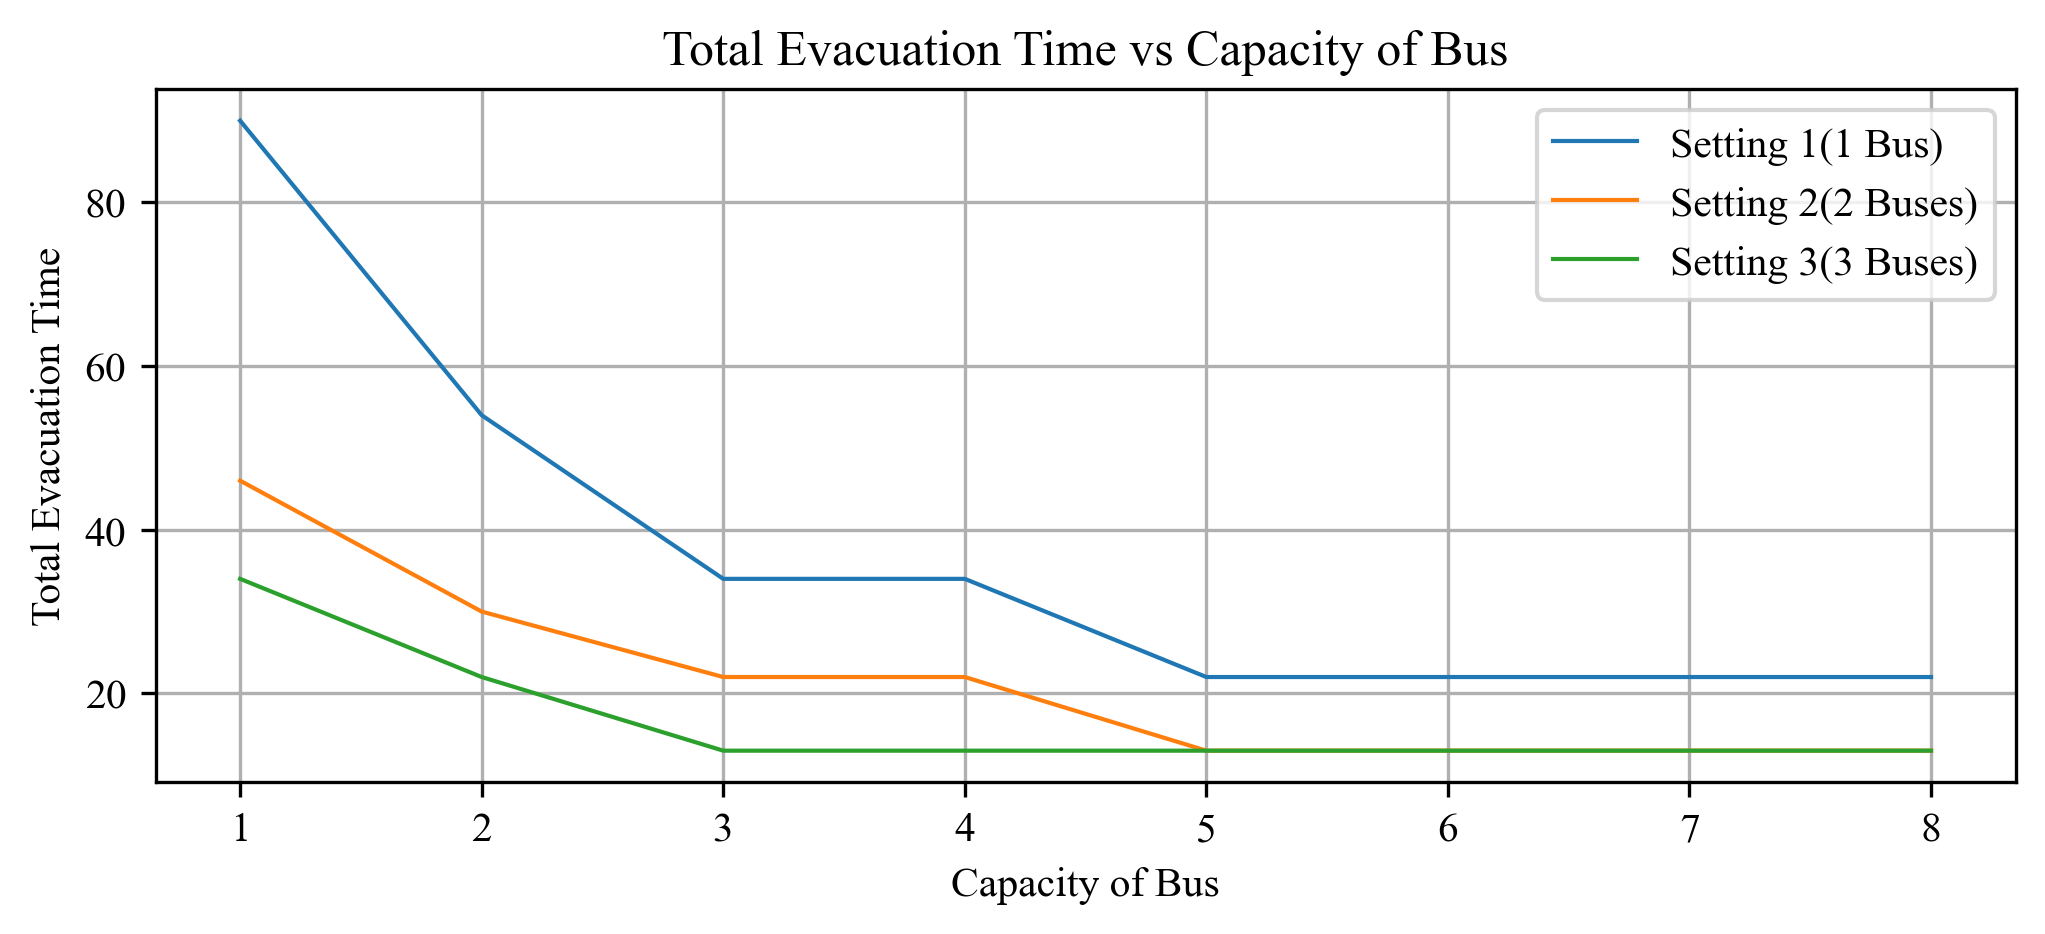

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3),dpi=300)
plt.rcParams["font.family"] = "Times New Roman"
t_m_1=[90,54,34,34,22,22,22,22]
t_m_2=[46,30,22,22,13,13,13,13]
t_m_3=[34,22,13,13,13,13,13,13]
bus_c=[1,2,3,4,5,6,7,8]

plt.plot(bus_c, t_m_1,linewidth=1,label="Setting 1(1 Bus)")
plt.plot(bus_c, t_m_2,linewidth=1,label="Setting 2(2 Buses)")
plt.plot(bus_c, t_m_3,linewidth=1,label="Setting 3(3 Buses)")

plt.xlabel("Capacity of Bus")
plt.ylabel("Total Evacuation Time")
plt.title("Total Evacuation Time vs Capacity of Bus")
plt.legend()
plt.grid()